In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [3]:
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [22]:
import pickle

def covert_into_pickle(item, directory):
    pickle.dump(item, open(directory,'wb'))

def load_from_pickle(directory):
    return pickle.load(open(directory,'rb'))

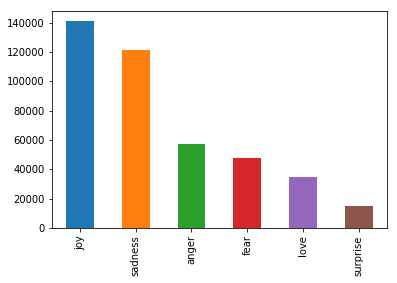

In [23]:
#load data
data = load_from_pickle(directory='C:/Users/Sumanyu/Code/emotion-detection/merged_training.pkl')
data.emotions.value_counts().plot.bar()

In [24]:
print(data.shape)
print(type(data))

(416809, 2)
<class 'pandas.core.frame.DataFrame'>


In [25]:
data.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [50]:
#copying data with number of tokens less than 70
data["token size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data["token size"] < 70].copy()

#sampling data
data = data.sample(n=5000)

In [33]:
#from nltk import word_tokenize

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sumanyu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [51]:
class ConstructDictionary():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2index = {}
        self.index2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        
        #creating tokens from sentences and adding them to dictionary
        for sentence in self.sentences:
            self.vocab.update(word_tokenize(sentence))
            
        #sorting the dictionary
        self.vocab = sorted(self.vocab)
        
        #adding padding token to 0 index
        self.word2index['<pad>'] = 0
           
        #creating a word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2index[word] = index + 1         #adding 1 becuase of padding element at 0 index
            
        #creating a index to word mapping
        for index, word in self.word2index.items():
            self.index2word[index] = word

In [52]:
inputs = ConstructDictionary(data["text"].values.tolist())
inputs.vocab[:10]

['a',
 'aa',
 'aaaaaaaall',
 'abandoned',
 'abandoning',
 'abandonment',
 'abby',
 'abdomen',
 'abefc',
 'abel']

In [53]:
len(inputs.vocab)

8196

In [54]:
input_tensors = [[inputs.word2index[word] for word in word_tokenize(sentence) ] for sentence in data['text'].values.tolist() ]
input_tensors[:2]

[[3574,
  4877,
  2683,
  3468,
  271,
  825,
  979,
  3539,
  4146,
  3392,
  3413,
  4996,
  4722,
  789,
  414,
  3557,
  3374,
  5784,
  7363,
  1976,
  3854,
  7376,
  8167,
  7241,
  3539,
  8105,
  2738,
  4847,
  695,
  4302,
  7980,
  3374,
  4003,
  4722,
  4206,
  3851,
  8175,
  3539,
  7283,
  4959,
  3539,
  4785,
  7363,
  3581,
  8167,
  3624,
  5027,
  7363,
  3022,
  4960],
 [3539,
  2680,
  731,
  7963,
  1096,
  1228,
  721,
  7982,
  5053,
  2622,
  3024,
  7374,
  979,
  8159,
  4722,
  2622,
  3826,
  4847,
  7982,
  7363,
  601,
  2875]]

In [55]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [57]:
max_length_input = max_length(input_tensors)
print(max_length_input)

62


In [65]:
def pad_sequences(x, max_len=max_length_input):
    padded = np.zeros((max_len), dtype=np.int64)
    padded[:len(x)] = x
    return padded

In [66]:
input_tensors = [pad_sequences(x, max_length_input) for x in input_tensors]
input_tensors[:2]

[array([3574, 4877, 2683, 3468,  271,  825,  979, 3539, 4146, 3392, 3413,
        4996, 4722,  789,  414, 3557, 3374, 5784, 7363, 1976, 3854, 7376,
        8167, 7241, 3539, 8105, 2738, 4847,  695, 4302, 7980, 3374, 4003,
        4722, 4206, 3851, 8175, 3539, 7283, 4959, 3539, 4785, 7363, 3581,
        8167, 3624, 5027, 7363, 3022, 4960,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0], dtype=int64),
 array([3539, 2680,  731, 7963, 1096, 1228,  721, 7982, 5053, 2622, 3024,
        7374,  979, 8159, 4722, 2622, 3826, 4847, 7982, 7363,  601, 2875,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0], dtype=int64)]

In [71]:
#now we are using transforming our target values using one-hot encoding

emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)

mlb = preprocessing.MultiLabelBinarizer()

data_labels = [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [72]:
target_tensor[:2]

array([[0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [80]:
def get_emotion(x):
    return np.argmax(x)

In [81]:
get_emotion(target_tensor[0])

3

In [82]:
emotion_dict = {0:'anger', 1:'love', 2:'joy', 3:'sadness', 4:'fear', 5:'surprise'}

In [83]:
emotion_dict[get_emotion(target_tensor[0])]

'sadness'